# **Trip Duration Prediction 🚕**

We will analyze data taken from taxi rides in the New York broader area and try to fit them in order to predict the trip duration. More specifically we will be experimenting with the following:

* Analyze the dataset, plot some graphs and extract some meaningfull patterns of data
* Clustering the data using **K-Means** algorithm (+ will find the optimal number of clusters)
* Use **Random Forest Regressor** for predicting the estimated trip duration (+ hyperparameter tuning)
* As a bonus task we will create a **map of the New York** with the pick-up and drop-off points of the rides and we will perform some furter data analysis with our focus on traffic times.

## **Load the dataset** 🗂

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
train_path = '/content/drive/My Drive/DataMiningProject2-Data/train.csv'
test_path = '/content/drive/My Drive/DataMiningProject2-Data/test.csv'
target_path = '/content/drive/My Drive/DataMiningProject2-Data/target.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
target_df = pd.read_csv(target_path)

train_df = train_df.head(150000) 
test_df = test_df.head(150000) 
target_df = target_df.head(150000) 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Data Analysis** 🔍

In this section, we will take a deep look at our data and with the help of some graphs we will try to draw some meaningful conclusions about the data. We divide this section into nine data questions, each of which addresses a different aspect of the data. 


#### **Q. 𝐈 -- Data Description**

In [ ]:
train_df.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  150000.000000    150000.000000     150000.000000    150000.000000   
mean        1.534873         1.662587        -73.973425        40.750997   
std         0.498784         1.311230          0.040220         0.029164   
min         1.000000         0.000000        -75.238327        39.923027   
25%         1.000000         1.000000        -73.991829        40.737335   
50%         2.000000         1.000000        -73.981827        40.754097   
75%         2.000000         2.000000        -73.967270        40.768360   
max         2.000000         6.000000        -70.511902        43.017578   

       dropoff_longitude  dropoff_latitude  trip_duration  
count      150000.000000     150000.000000  150000.000000  
mean          -73.973254         40.752001     946.515493  
std             0.038159          0.033413    3108.625779  
min           -74.705360         40.271030       1.000000  
25%           -73.991280         40.736019     397.000000  
50%           -73.979698         40.754509     663.000000  
75%           -73.962929         40.769939    1073.000000  
max           -70.511902         43.017578   86362.000000

**Two first words on the description of the data**

* **Vendor ID** has a minimum value of 1 and a maximum value of 2 so there are just two vendor of taxis. 
* **Passenger count** has a minimum of 0 which means either it is an error entered or the drivers deliberately entered 0 to complete a target number of rides, and a maximum value of 6. *On average, each ride has 1.7 passengers* which seems reasonable.
* The **trip duration** is on average about 16 minutes. This also seems reasonable, as New York is almost always very busy. We will further discuss trip duration in a later section.


**Remove outliers** (entries where their trip duration is more than 2 standard deviations away from the mean value).

In [ ]:
import numpy as np

mean = np.mean(train_df['trip_duration'], axis=0)
std = np.std(train_df['trip_duration'], axis=0)

train_df = train_df[abs(train_df.trip_duration - mean) <= 2*std]

In [ ]:
train_df.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2575240          2  2016-04-09 08:41:59  2016-04-09 08:48:11   
1  id3828278          2  2016-04-07 11:12:45  2016-04-07 11:24:24   
2  id1483137          2  2016-04-15 19:53:35  2016-04-15 20:04:49   
3  id0416660          2  2016-04-21 00:47:17  2016-04-21 00:53:41   
4  id2363476          1  2016-01-26 18:34:23  2016-01-26 19:09:14   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.976501        40.788368         -73.957657   
1                1        -73.992310        40.769211         -73.990662   
2                1        -73.994713        40.746391         -73.969742   
3                1        -73.988358        40.718460         -73.951538   
4                1        -73.992332        40.743576         -73.979309   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.782452                  N            372  
1         40.758137                  N            699  
2         40.758484                  N            674  
3         40.713840                  N            384  
4         40.678200                  N           2091

#### **Q. 𝐈𝐈 -- Keep it in New York**

We will focus on the New York area, so, we're removing points that are outside the New York City limits.

In [ ]:
city_long_border_min = -74.03
city_long_border_max = -73.75
city_lat_border_min = 40.63
city_lat_border_max = 40.85

In [ ]:
train_df = train_df[(train_df.pickup_longitude > city_long_border_min) & (train_df.pickup_longitude < city_long_border_max) & (train_df.pickup_latitude > city_lat_border_min) & (train_df.pickup_latitude < city_lat_border_max) & (train_df.dropoff_longitude > city_long_border_min) & (train_df.dropoff_longitude < city_long_border_max) & (train_df.dropoff_latitude > city_lat_border_min) & (train_df.dropoff_latitude < city_lat_border_max)]
# test_df = test_df[(test_df.pickup_longitude > city_long_border_min) & (test_df.pickup_longitude < city_long_border_max) & (test_df.pickup_latitude > city_lat_border_min) & (test_df.pickup_latitude < city_lat_border_max) & (test_df.dropoff_longitude > city_long_border_min) & (test_df.dropoff_longitude < city_long_border_max) & (test_df.dropoff_latitude > city_lat_border_min) & (test_df.dropoff_latitude < city_lat_border_max)]

#### **Q. 𝐈𝐈𝐈 -- About datetime columns**

We will add the following columns on the dataset:

* `day_period`: Morning, Afternoon, Evening, Late Night
* `day_name`: Monday, Tuesday, .., Sunday
* `month`: January, February, .., December
* `hour`: in 24 hour format
* `year`: the year
* `season`: Spring, Summer, Autumn, Winter

All of the above will be added for pick-up and drop-off points only in the training set. In the test set, we will create the above for the pickup points only (as the dropoff points aren't available for the test set).


In [ ]:
import datetime

In [ ]:
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])
train_df['dropoff_datetime'] = pd.to_datetime(train_df['dropoff_datetime'])

test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'])

In [ ]:
def season(month):
  if month in range(3,6):
    return 'Spring'
  elif month in range(6,9):
    return 'Summer'
  elif month in range(9,12):
    return 'Autumn'
  else:
    return 'Winter'

In [ ]:
def day_period(hour):
  if hour >= 6 and hour < 12:
    return 'Morning'
  elif hour >= 12 and hour < 16:
    return 'Afternoon'
  elif hour >= 16 and hour < 22:
    return 'Evening'
  else:
    return 'Late Night' 

In [ ]:
def day_name(day):
  switcher = { 
    0:
      "Monday",
    1:
      "Tuesday",
    2:
      "Wednesday",
    3:
      "Thursday",
    4:
      "Friday",
    5:
      "Saturday",
    6:
      "Sunday"
  }
  return switcher.get(day)

In [ ]:
def month_name(month):
  switcher = { 
    1:
      "January",
    2:
      "February",
    3:
      "March",
    4:
      "April",
    5:
      "May",
    6:
      "June",
    7:
      "July",
    8:
      "August",
    9: 
      "September",
    10:
      "October",
    11:
      "November",
    12:
      "December"
  }
  return switcher.get(month)

In [ ]:
train_df['pickup_day_period'] = train_df['pickup_datetime'].dt.hour.apply(day_period)
train_df['pickup_day_name'] = train_df['pickup_datetime'].dt.weekday.apply(day_name)
train_df['pickup_month'] = train_df['pickup_datetime'].dt.month.apply(month_name)
train_df['pickup_hour'] = train_df['pickup_datetime'].dt.hour
train_df['pickup_year'] = train_df['pickup_datetime'].dt.year 
train_df['pickup_season'] = train_df['pickup_datetime'].dt.month.apply(season)

train_df['dropoff_day_period'] = train_df['dropoff_datetime'].dt.hour.apply(day_period)
train_df['dropoff_day_name'] = train_df['dropoff_datetime'].dt.weekday.apply(day_name)
train_df['dropoff_month'] = train_df['dropoff_datetime'].dt.month.apply(month_name)
train_df['dropoff_hour'] = train_df['dropoff_datetime'].dt.hour
train_df['dropoff_year'] = train_df['dropoff_datetime'].dt.year 
train_df['dropoff_season'] = train_df['dropoff_datetime'].dt.month.apply(season)

test_df['pickup_day_period'] = test_df['pickup_datetime'].dt.hour.apply(day_period)
test_df['pickup_day_name'] = test_df['pickup_datetime'].dt.weekday.apply(day_name)
test_df['pickup_month'] = test_df['pickup_datetime'].dt.month.apply(month_name)
test_df['pickup_hour'] = test_df['pickup_datetime'].dt.hour
test_df['pickup_year'] = test_df['pickup_datetime'].dt.year 
test_df['pickup_season'] = test_df['pickup_datetime'].dt.month.apply(season)

In [ ]:
pd.set_option('display.max_columns', None)
train_df

id  vendor_id     pickup_datetime    dropoff_datetime  \
0       id2575240          2 2016-04-09 08:41:59 2016-04-09 08:48:11   
1       id3828278          2 2016-04-07 11:12:45 2016-04-07 11:24:24   
2       id1483137          2 2016-04-15 19:53:35 2016-04-15 20:04:49   
3       id0416660          2 2016-04-21 00:47:17 2016-04-21 00:53:41   
4       id2363476          1 2016-01-26 18:34:23 2016-01-26 19:09:14   
...           ...        ...                 ...                 ...   
149994  id2764327          1 2016-03-16 14:22:03 2016-03-16 14:51:42   
149995  id3637285          2 2016-05-09 19:54:44 2016-05-09 20:05:57   
149996  id0191484          1 2016-01-17 00:14:54 2016-01-17 00:17:47   
149997  id0661284          2 2016-01-15 14:11:39 2016-01-15 14:28:08   
149998  id0353122          2 2016-05-29 16:15:59 2016-05-29 16:36:37   

        passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                     1        -73.976501        40.788368         -73.957657   
1                     1        -73.992310        40.769211         -73.990662   
2                     1        -73.994713        40.746391         -73.969742   
3                     1        -73.988358        40.718460         -73.951538   
4                     1        -73.992332        40.743576         -73.979309   
...                 ...               ...              ...                ...   
149994                2        -73.978401        40.752426         -73.989975   
149995                4        -73.870888        40.773716         -73.925484   
149996                1        -73.973244        40.789829         -73.963272   
149997                6        -73.991814        40.737831         -73.984528   
149998                5        -73.983559        40.760448         -74.016068   

        dropoff_latitude store_and_fwd_flag  trip_duration pickup_day_period  \
0              40.782452                  N            372           Morning   
1              40.758137                  N            699           Morning   
2              40.758484                  N            674           Evening   
3              40.713840                  N            384        Late Night   
4              40.678200                  N           2091           Evening   
...                  ...                ...            ...               ...   
149994         40.750263                  N           1779         Afternoon   
149995         40.767742                  N            673           Evening   
149996         40.798786                  N            173        Late Night   
149997         40.763969                  N            989         Afternoon   
149998         40.714668                  N           1238           Evening   

       pickup_day_name pickup_month  pickup_hour  pickup_year pickup_season  \
0             Saturday        April            8         2016        Spring   
1             Thursday        April           11         2016        Spring   
2               Friday        April           19         2016        Spring   
3             Thursday        April            0         2016        Spring   
4              Tuesday      January           18         2016        Winter   
...                ...          ...          ...          ...           ...   
149994       Wednesday        March           14         2016        Spring   
149995          Monday          May           19         2016        Spring   
149996          Sunday      January            0         2016        Winter   
149997          Friday      January           14         2016        Winter   
149998          Sunday          May           16         2016        Spring   

       dropoff_day_period dropoff_day_name dropoff_month  dropoff_hour  \
0                 Morning         Saturday         April             8   
1                 Morning         Thursday         April            11   
2                 Evening           Friday   

**Busiest days**

In [ ]:
from pandas import Grouper, to_datetime

groupedby_pickup_day = train_df.groupby([train_df['pickup_day_name']])['pickup_day_name'].count().reset_index(name="count")
groupedby_dropoff_day = train_df.groupby([train_df['dropoff_day_name']])['dropoff_day_name'].count().reset_index(name="count")

In [ ]:
groupedby_pickup_day

pickup_day_name  count
0          Friday  22475
1          Monday  19050
2        Saturday  22413
3          Sunday  19748
4        Thursday  22325
5         Tuesday  20371
6       Wednesday  21370

In [ ]:
busiest_pickup_days = groupedby_pickup_day.nlargest(2, "count")
busiest_dropoff_days = groupedby_dropoff_day.nlargest(2, "count")

**Busiest pick-up days**

In [ ]:
busiest_pickup_days

pickup_day_name  count
0          Friday  22475
2        Saturday  22413

[Text(0, 0.5, 'Trips'),
 Text(0.5, 0, 'Day'),
 Text(0.5, 1.0, 'Busiest pick-up days')]

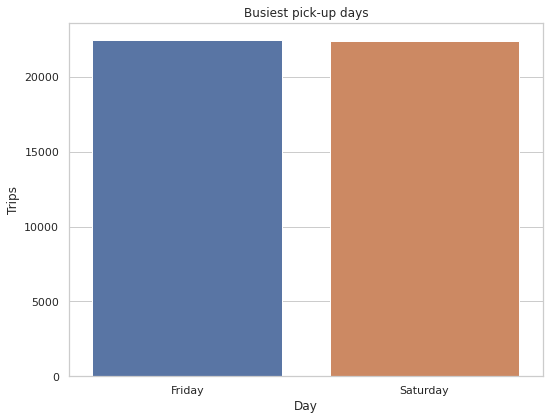

In [ ]:
import seaborn as sns

sns.set(rc={'figure.figsize':(8.5,6.5)})
sns.set(style="whitegrid", color_codes=True)
data = busiest_pickup_days

pal = sns.color_palette("tab10", len(busiest_pickup_days))
ax = sns.barplot(x=data['pickup_day_name'], y=data['count'])
ax.set(xlabel='Day', ylabel='Trips', title='Busiest pick-up days')

We see Fridays are the busiest days followed by Saturdays. That is probably because it’s weekend.

**Busiest drop-off days**

[Text(0, 0.5, 'Trips'),
 Text(0.5, 0, 'Day'),
 Text(0.5, 1.0, 'Busiest drop-off days')]

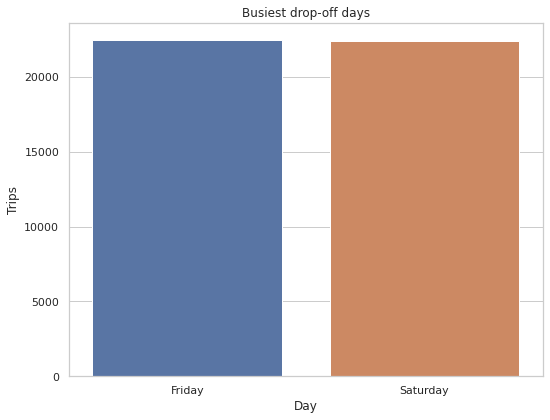

In [ ]:
sns.set(rc={'figure.figsize':(8.5,6.5)})
sns.set(style="whitegrid", color_codes=True)
data = busiest_dropoff_days

pal = sns.color_palette("tab10", len(busiest_dropoff_days))
ax = sns.barplot(x=data['dropoff_day_name'], y=data['count'])
ax.set(xlabel='Day', ylabel='Trips', title='Busiest drop-off days')

**Trips per day period (pick-up & drop-off)**

In [ ]:
groupedby_pickup_day_period = train_df.groupby("pickup_day_period").size()
groupedby_dropoff_day_period = train_df.groupby("dropoff_day_period").size()

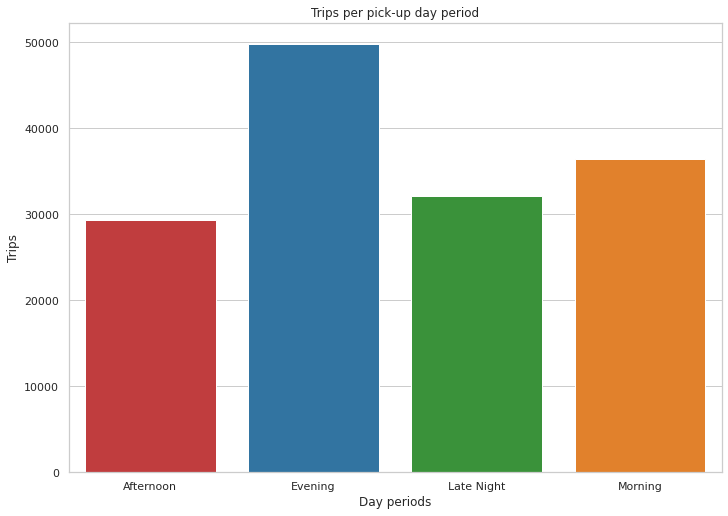

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid", color_codes=True)
data = groupedby_pickup_day_period

pal = sns.color_palette("tab10", len(groupedby_pickup_day_period))
rank = groupedby_pickup_day_period.argsort().argsort()   
ax = sns.barplot(x=data.index, y=groupedby_pickup_day_period, palette=np.array(pal[::-1])[rank])
ax.set(xlabel='Day periods', ylabel='Trips', title='Trips per pick-up day period')
plt.show()

[Text(0, 0.5, 'Trips'),
 Text(0.5, 0, 'Day periods'),
 Text(0.5, 1.0, 'Trips per drop-off day period')]

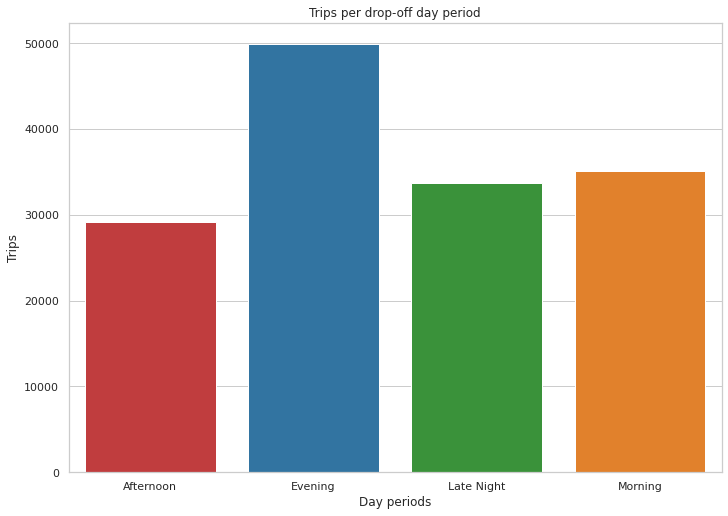

In [ ]:
sns.set(style="whitegrid", color_codes=True)
data = groupedby_dropoff_day_period

pal = sns.color_palette("tab10", len(groupedby_dropoff_day_period))
rank = groupedby_dropoff_day_period.argsort().argsort()   
ax = sns.barplot(x=data.index, y=groupedby_dropoff_day_period, palette=np.array(pal[::-1])[rank])
ax.set(xlabel='Day periods', ylabel='Trips', title='Trips per drop-off day period')

We see that the busiest period of the day is the evening.

**Trips per month (pick-up & drop-off)**

In [ ]:
groupedby_pickup_month = train_df.groupby("pickup_month").size()
groupedby_dropoff_month = train_df.groupby("dropoff_month").size()

In [ ]:
groupedby_pickup_month.index

Index(['April', 'February', 'January', 'June', 'March', 'May'], dtype='object', name='pickup_month')

Text(0.5, 1.0, 'Average number of trips per pick-up month')

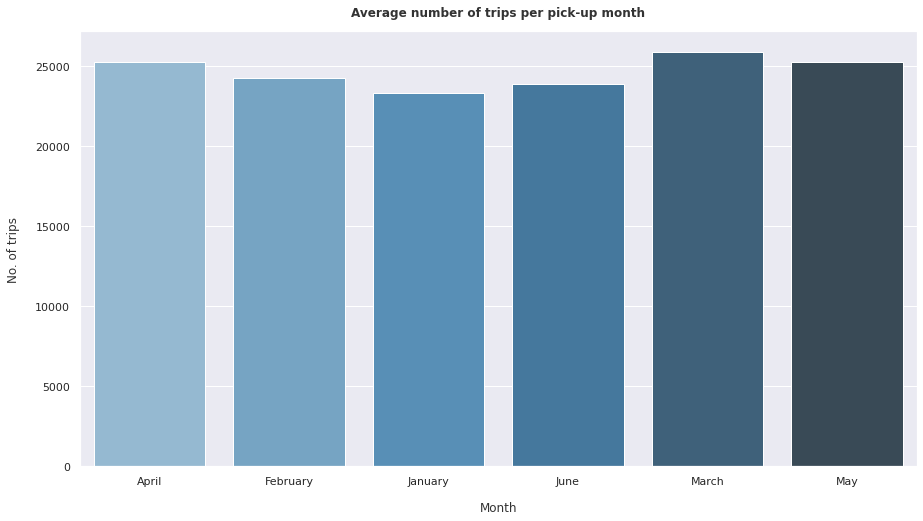

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x = groupedby_pickup_month.index, y = groupedby_pickup_month.values, data = pd.DataFrame(groupedby_pickup_month), palette=("Blues_d"))
ax.set_xlabel('Month', labelpad=15, color='#333333')
ax.set_ylabel('No. of trips', labelpad=15, color='#333333')
ax.set_title('Average number of trips per pick-up month', pad=15, color='#333333', weight='bold')

Text(0.5, 1.0, 'Average number of trips per drop-off month')

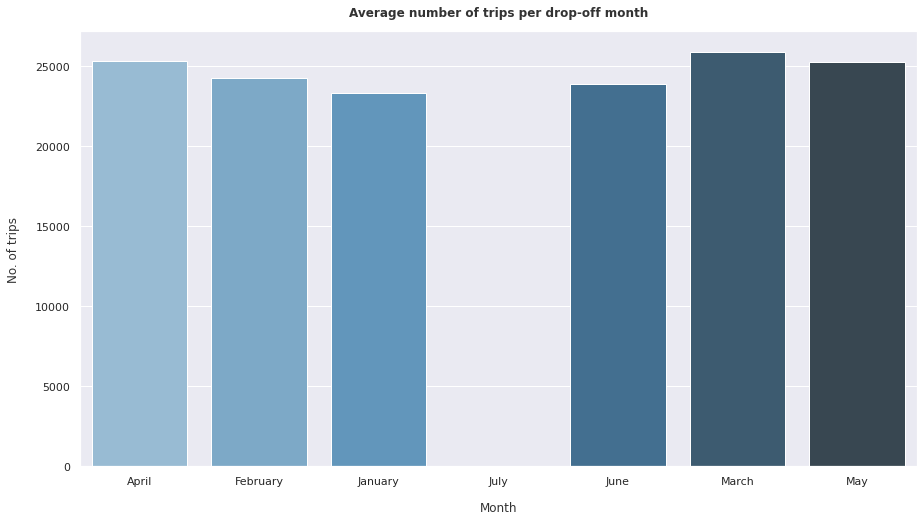

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x = groupedby_dropoff_month.index, y = groupedby_dropoff_month.values, data = pd.DataFrame(groupedby_dropoff_month), palette=("Blues_d"))
ax.set_xlabel('Month', labelpad=15, color='#333333')
ax.set_ylabel('No. of trips', labelpad=15, color='#333333')
ax.set_title('Average number of trips per drop-off month', pad=15, color='#333333', weight='bold')

There is not much difference in the number of trips across months.

**Average trip duration per hour**

In [ ]:
trip_dur_per_hour = train_df.groupby('pickup_hour')['trip_duration'].agg(['sum','count'])
trip_dur_per_hour['average_trip_duration'] = trip_dur_per_hour['sum']/trip_dur_per_hour['count']/60

Text(0.5, 1.0, 'Average trip duration per hour')

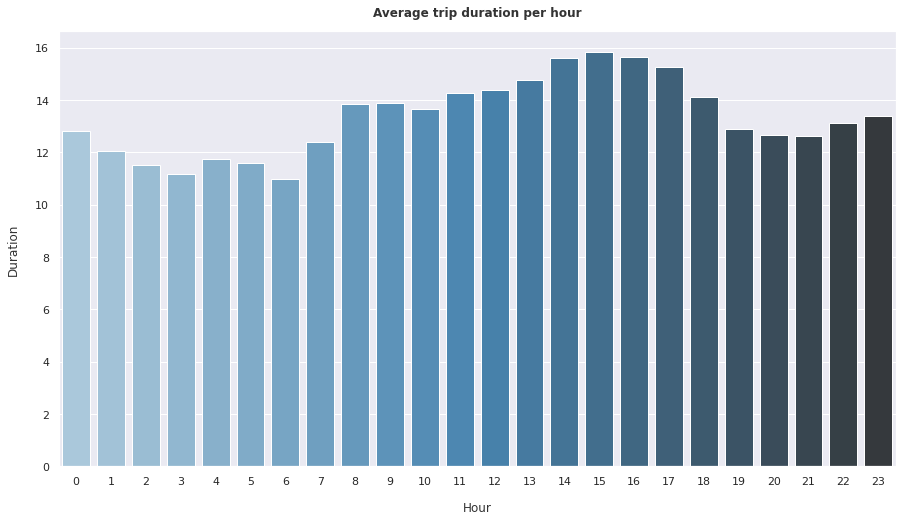

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x = trip_dur_per_hour.index, y = "average_trip_duration", data = trip_dur_per_hour, palette=("Blues_d"))
ax.set_xlabel('Hour', labelpad=15, color='#333333')
ax.set_ylabel('Duration', labelpad=15, color='#333333')
ax.set_title('Average trip duration per hour', pad=15, color='#333333', weight='bold')

We see the trip duration is the maximum around 3 pm which may be because of traffic on the roads.
Trip duration is the lowest around 6 am as streets may not be busy.

**Average trip duration per day period**

In [ ]:
trip_dur_per_day_period = train_df.groupby('pickup_day_period')['trip_duration'].agg(['sum','count'])
trip_dur_per_day_period['average_trip_duration'] = trip_dur_per_day_period['sum']/trip_dur_per_day_period['count']/60

In [ ]:
trip_dur_per_day_period

sum  count  average_trip_duration
pickup_day_period                                        
Afternoon          26631265  29297              15.150166
Evening            41156642  49794              13.775636
Late Night         24328958  32167              12.605547
Morning            29357820  36494              13.407601

Text(0.5, 1.0, 'Average trip duration per day period')

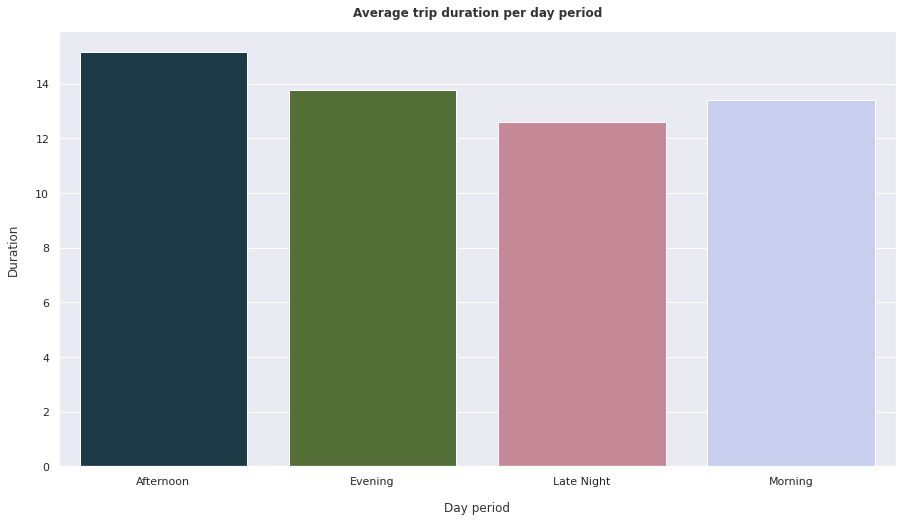

In [ ]:
ax = sns.barplot(x = trip_dur_per_day_period.index, y = "average_trip_duration", data = trip_dur_per_day_period, palette=("cubehelix"))
ax.set_xlabel('Day period', labelpad=15, color='#333333')
ax.set_ylabel('Duration', labelpad=15, color='#333333')
ax.set_title('Average trip duration per day period', pad=15, color='#333333', weight='bold')

The hours that have a longer trip duration are between 14:00 - 17:00 which are distributed up to 15:00 in the afternoon while the rest and up to 22:00 is evening. The average trip duration per period of the day then logically leans towards afternoon where the hours from 12:00 to 15:00 have a very high trip duration. This is also true for the first hours of the evening period but up to 17:00 while the trip duration in the hours 20:00-21:00 is quite low.

**Average trip duration per week-day**

In [ ]:
trip_dur_per_day = train_df.groupby('pickup_day_name')['trip_duration'].agg(['sum','count'])
trip_dur_per_day['average_trip_duration'] = trip_dur_per_day['sum']/trip_dur_per_day['count']/60

In [ ]:
trip_dur_per_day

sum  count  average_trip_duration
pickup_day_name                                        
Friday           19183677  22475              14.225938
Monday           15111474  19050              13.220887
Saturday         17192947  22413              12.784951
Sunday           14831360  19748              12.517183
Thursday         19629946  22325              14.654682
Tuesday          17084955  20371              13.978167
Wednesday        18440326  21370              14.381786

Text(0.5, 1.0, 'Average trip duaration per day')

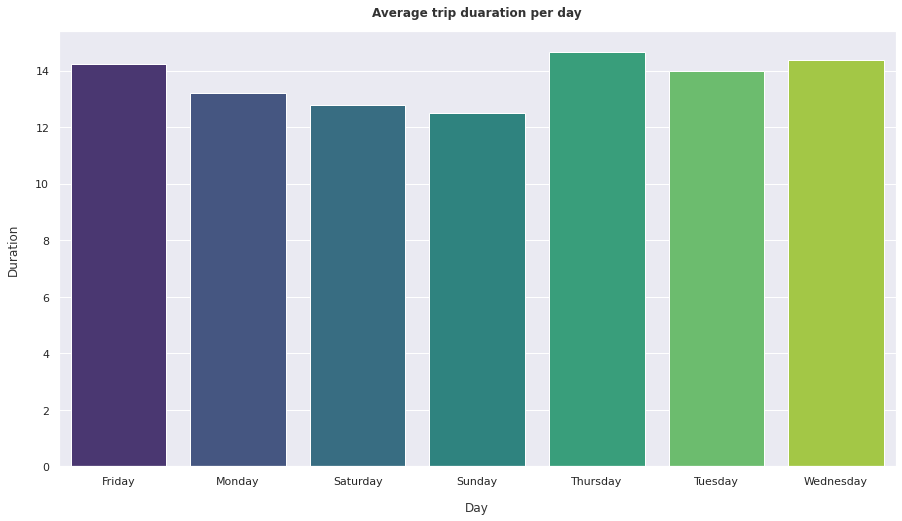

In [ ]:
ax = sns.barplot(x = trip_dur_per_day.index, y = "average_trip_duration", data = trip_dur_per_day, palette=("viridis"))
ax.set_xlabel('Day', labelpad=15, color='#333333')
ax.set_ylabel('Duration', labelpad=15, color='#333333')
ax.set_title('Average trip duaration per day', pad=15, color='#333333', weight='bold')

The highest average time taken to complete a trip is on Thursday while Monday, Saturday and Sunday takes the least time.

#### **Q. 𝐈𝐕 -- Log trip duration**

In [ ]:
train_df

id  vendor_id     pickup_datetime    dropoff_datetime  \
0       id2575240          2 2016-04-09 08:41:59 2016-04-09 08:48:11   
1       id3828278          2 2016-04-07 11:12:45 2016-04-07 11:24:24   
2       id1483137          2 2016-04-15 19:53:35 2016-04-15 20:04:49   
3       id0416660          2 2016-04-21 00:47:17 2016-04-21 00:53:41   
4       id2363476          1 2016-01-26 18:34:23 2016-01-26 19:09:14   
...           ...        ...                 ...                 ...   
149994  id2764327          1 2016-03-16 14:22:03 2016-03-16 14:51:42   
149995  id3637285          2 2016-05-09 19:54:44 2016-05-09 20:05:57   
149996  id0191484          1 2016-01-17 00:14:54 2016-01-17 00:17:47   
149997  id0661284          2 2016-01-15 14:11:39 2016-01-15 14:28:08   
149998  id0353122          2 2016-05-29 16:15:59 2016-05-29 16:36:37   

        passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                     1        -73.976501        40.788368         -73.957657   
1                     1        -73.992310        40.769211         -73.990662   
2                     1        -73.994713        40.746391         -73.969742   
3                     1        -73.988358        40.718460         -73.951538   
4                     1        -73.992332        40.743576         -73.979309   
...                 ...               ...              ...                ...   
149994                2        -73.978401        40.752426         -73.989975   
149995                4        -73.870888        40.773716         -73.925484   
149996                1        -73.973244        40.789829         -73.963272   
149997                6        -73.991814        40.737831         -73.984528   
149998                5        -73.983559        40.760448         -74.016068   

        dropoff_latitude store_and_fwd_flag  trip_duration pickup_day_period  \
0              40.782452                  N            372           Morning   
1              40.758137                  N            699           Morning   
2              40.758484                  N            674           Evening   
3              40.713840                  N            384        Late Night   
4              40.678200                  N           2091           Evening   
...                  ...                ...            ...               ...   
149994         40.750263                  N           1779         Afternoon   
149995         40.767742                  N            673           Evening   
149996         40.798786                  N            173        Late Night   
149997         40.763969                  N            989         Afternoon   
149998         40.714668                  N           1238           Evening   

       pickup_day_name pickup_month  pickup_hour  pickup_year pickup_season  \
0             Saturday        April            8         2016        Spring   
1             Thursday        April           11         2016        Spring   
2               Friday        April           19         2016        Spring   
3             Thursday        April            0         2016        Spring   
4              Tuesday      January           18         2016        Winter   
...                ...          ...          ...          ...           ...   
149994       Wednesday        March           14         2016        Spring   
149995          Monday          May           19         2016        Spring   
149996          Sunday      January            0         2016        Winter   
149997          Friday      January           14         2016        Winter   
149998          Sunday          May           16         2016        Spring   

       dropoff_day_period dropoff_day_name dropoff_month  dropoff_hour  \
0                 Morning         Saturday         April             8   
1                 Morning         Thursday         April            11   
2                 Evening           Friday   

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6824c62410>]],
      dtype=object)

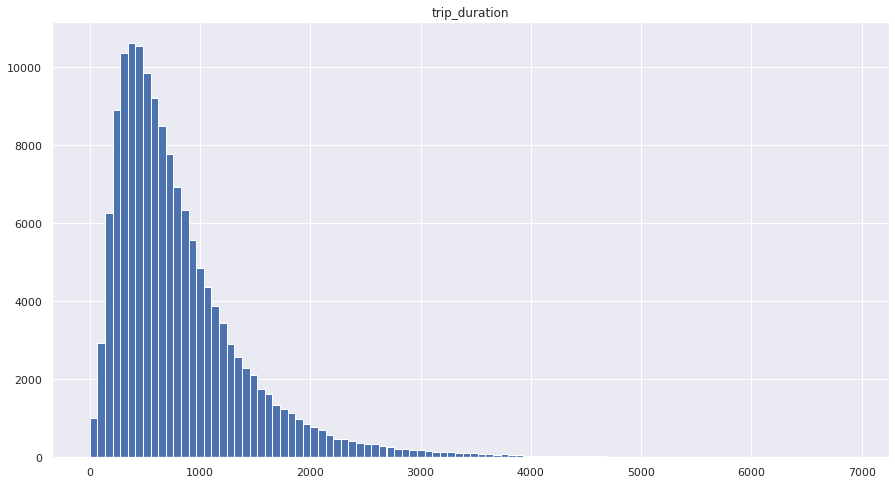

In [ ]:
train_df.hist(column='trip_duration', bins = 100)

In [ ]:
train_df['log_trip_duration'] = np.log2(train_df['trip_duration'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f68242aba10>]],
      dtype=object)

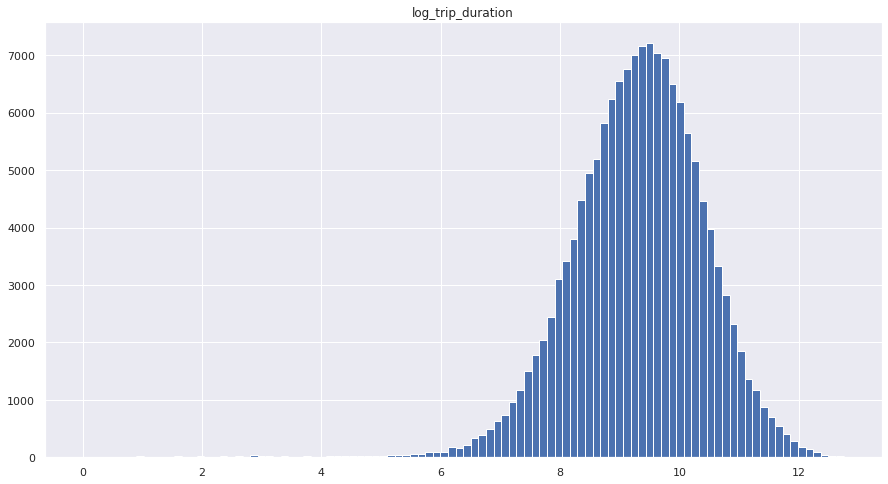

In [ ]:
train_df.hist(column='log_trip_duration', bins = 100)

#### **Q. 𝐕 -- Trip duration per vendor**

In [ ]:
trip_dur_per_vendor = train_df.groupby('vendor_id')['trip_duration'].agg(['sum','count'])
trip_dur_per_vendor['average_trip_duration'] = trip_dur_per_vendor['sum']/trip_dur_per_vendor['count']/60

In [ ]:
trip_dur_per_vendor

sum  count  average_trip_duration
vendor_id                                        
1          56179784  68791              13.611224
2          65294901  78961              13.782099

Text(0.5, 1.0, 'Average trip duration per vendor')

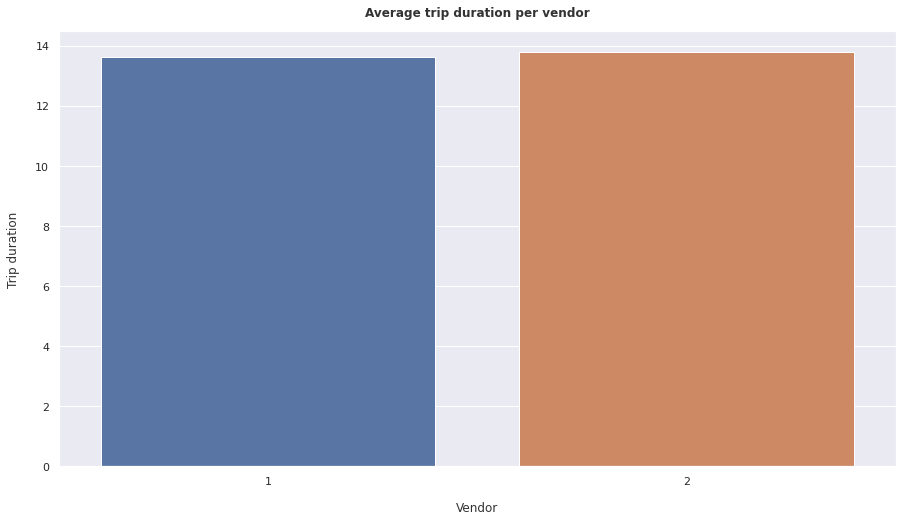

In [ ]:
ax = sns.barplot(x = trip_dur_per_vendor.index, y = "average_trip_duration", data = trip_dur_per_vendor)
ax.set_xlabel('Vendor', labelpad=15, color='#333333')
ax.set_ylabel('Trip duration', labelpad=15, color='#333333')
ax.set_title('Average trip duration per vendor', pad=15, color='#333333', weight='bold')

The distribution of vendor id does not differ much, as expected.


#### **Q. 𝐕𝐈 -- Passengers & Trip duration**

How does the number of passengers affect the duration of the trip?

In [ ]:
grouped_df = train_df.groupby("passenger_count")
mean_df = grouped_df.mean()
mean_df = mean_df.reset_index()

mean_df = mean_df[['trip_duration','passenger_count']]
mean_df['trip_duration'] = mean_df['trip_duration'].div(60)
print(mean_df)

   trip_duration  passenger_count
0       2.433333                0
1      13.520200                1
2      14.315819                2
3      13.914283                3
4      14.616952                4
5      13.954006                5
6      13.738753                6


From the above data, there is no visible relation between trip duration and passenger count.

#### **Q. 𝐕𝐈𝐈 -- Distances**

Since we have the geographical coordinates of both pickup and dropoff points, then we can calculate the distance of the trip using the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula).

In [ ]:
def haversine_dist(s_lat, s_lng, e_lat, e_lng):
   # approximate radius of earth in km
   R = 6371.0

   s_lat = s_lat*np.pi/180.0                      
   s_lng = np.deg2rad(s_lng)     
   e_lat = np.deg2rad(e_lat)                       
   e_lng = np.deg2rad(e_lng)  

   d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2

   return 2 * R * np.arcsin(np.sqrt(d))

In [ ]:
train_hav_dist = haversine_dist(train_df['pickup_latitude'].values, train_df['pickup_longitude'].values,
                    train_df['dropoff_latitude'].values, train_df['dropoff_longitude'].values)

test_hav_dist = haversine_dist(test_df['pickup_latitude'].values, test_df['pickup_longitude'].values,
                    test_df['dropoff_latitude'].values, test_df['dropoff_longitude'].values)

In [ ]:
train_hav_dist_df = pd.DataFrame(train_hav_dist)
test_hav_dist_df = pd.DataFrame(test_hav_dist)

In [ ]:
train_df['haversine_distance'] = train_hav_dist_df.values

In [ ]:
test_df['haversine_distance'] = test_hav_dist_df.values

In [ ]:
train_df

id  vendor_id     pickup_datetime    dropoff_datetime  \
0       id2575240          2 2016-04-09 08:41:59 2016-04-09 08:48:11   
1       id3828278          2 2016-04-07 11:12:45 2016-04-07 11:24:24   
2       id1483137          2 2016-04-15 19:53:35 2016-04-15 20:04:49   
3       id0416660          2 2016-04-21 00:47:17 2016-04-21 00:53:41   
4       id2363476          1 2016-01-26 18:34:23 2016-01-26 19:09:14   
...           ...        ...                 ...                 ...   
149994  id2764327          1 2016-03-16 14:22:03 2016-03-16 14:51:42   
149995  id3637285          2 2016-05-09 19:54:44 2016-05-09 20:05:57   
149996  id0191484          1 2016-01-17 00:14:54 2016-01-17 00:17:47   
149997  id0661284          2 2016-01-15 14:11:39 2016-01-15 14:28:08   
149998  id0353122          2 2016-05-29 16:15:59 2016-05-29 16:36:37   

        passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                     1        -73.976501        40.788368         -73.957657   
1                     1        -73.992310        40.769211         -73.990662   
2                     1        -73.994713        40.746391         -73.969742   
3                     1        -73.988358        40.718460         -73.951538   
4                     1        -73.992332        40.743576         -73.979309   
...                 ...               ...              ...                ...   
149994                2        -73.978401        40.752426         -73.989975   
149995                4        -73.870888        40.773716         -73.925484   
149996                1        -73.973244        40.789829         -73.963272   
149997                6        -73.991814        40.737831         -73.984528   
149998                5        -73.983559        40.760448         -74.016068   

        dropoff_latitude store_and_fwd_flag  trip_duration pickup_day_period  \
0              40.782452                  N            372           Morning   
1              40.758137                  N            699           Morning   
2              40.758484                  N            674           Evening   
3              40.713840                  N            384        Late Night   
4              40.678200                  N           2091           Evening   
...                  ...                ...            ...               ...   
149994         40.750263                  N           1779         Afternoon   
149995         40.767742                  N            673           Evening   
149996         40.798786                  N            173        Late Night   
149997         40.763969                  N            989         Afternoon   
149998         40.714668                  N           1238           Evening   

       pickup_day_name pickup_month  pickup_hour  pickup_year pickup_season  \
0             Saturday        April            8         2016        Spring   
1             Thursday        April           11         2016        Spring   
2               Friday        April           19         2016        Spring   
3             Thursday        April            0         2016        Spring   
4              Tuesday      January           18         2016        Winter   
...                ...          ...          ...          ...           ...   
149994       Wednesday        March           14         2016        Spring   
149995          Monday          May           19         2016        Spring   
149996          Sunday      January            0         2016        Winter   
149997          Friday      January           14         2016        Winter   
149998          Sunday          May           16         2016        Spring   

       dropoff_day_period dropoff_day_name dropoff_month  dropoff_hour  \
0                 Morning         Saturday         April             8   
1                 Morning         Thursday         April            11   
2                 Evening           Friday   

**Mean trip distance per weekday**

In [ ]:
# train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])
# train_df['dropoff_datetime'] = pd.to_datetime(train_df['dropoff_datetime'])
# train_df['pickup_day_name'] = train_df['pickup_datetime'].dt.weekday.apply(day_name)
# train_df['dropoff_day_name'] = train_df['dropoff_datetime'].dt.weekday.apply(day_name)

# test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'])
# test_df['pickup_day_name'] = test_df['pickup_datetime'].dt.weekday.apply(day_name)

In [ ]:
grouped_train_df = train_df.groupby("pickup_day_name")
mean_train_df = grouped_train_df.mean()
mean_train_df = mean_train_df.reset_index()

grouped_test_df = test_df.groupby("pickup_day_name")
mean_test_df = grouped_test_df.mean()
mean_test_df = mean_test_df.reset_index()

print(mean_train_df[['pickup_day_name','haversine_distance']])

  pickup_day_name  haversine_distance
0          Friday            3.269679
1          Monday            3.417886
2        Saturday            3.192835
3          Sunday            3.549967
4        Thursday            3.248232
5         Tuesday            3.189861
6       Wednesday            3.199620


In [ ]:
graph2data_train = mean_train_df[['pickup_day_name','haversine_distance']]
graph2data_test = mean_test_df[['pickup_day_name','haversine_distance']]

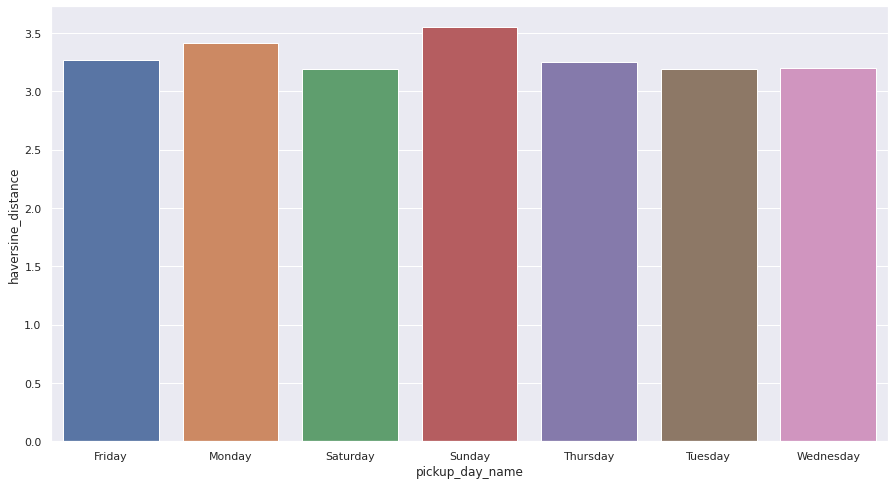

In [ ]:
sns.barplot(data=graph2data_train, x="pickup_day_name", y="haversine_distance")

There is not visible relation between days and trip distance

**Distance according to trip duration**

In [ ]:
train_df.dropna(subset=['trip_duration'], inplace=True)
hav_dist = train_df['haversine_distance']
trip_dur = train_df['trip_duration']

np_hav_dist = np.array(hav_dist)
np_trip_dur = np.array(trip_dur) / 60

dist_dur_df = pd.DataFrame({'haversine_distance': np_hav_dist, 'trip_duration': np_trip_dur})
print(dist_dur_df)

        haversine_distance  trip_duration
0                 1.717570       6.200000
1                 1.239177      11.650000
2                 2.496477      11.233333
3                 3.145381       6.400000
4                 7.351920      34.850000
...                    ...            ...
147747            1.004154      29.650000
147748            4.645324      11.216667
147749            1.302526       2.883333
147750            2.970543      16.483333
147751            5.780606      20.633333

[147752 rows x 2 columns]


**Scatterplot of distance and trip duration**

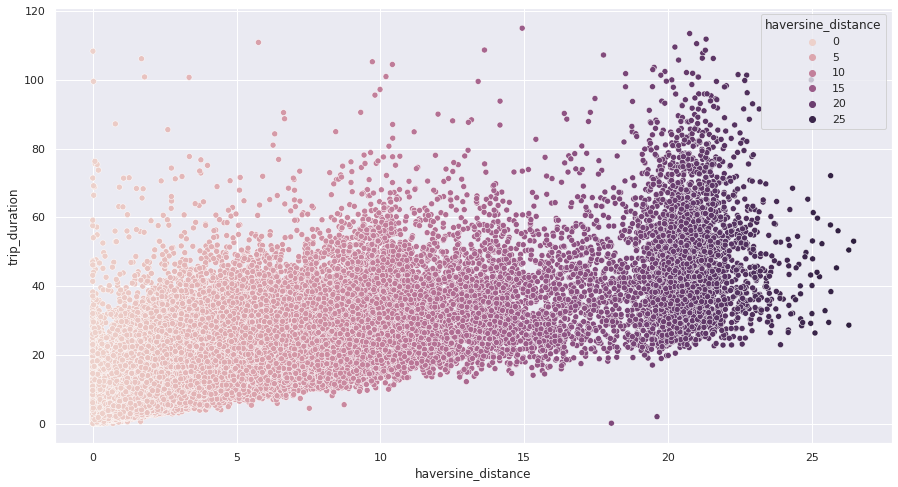

In [ ]:
sns.scatterplot(data=dist_dur_df, x="haversine_distance", y="trip_duration", hue="haversine_distance")

We can see some rides that have zero distance but non-zero trip duration, which is weird..

One reason can be that the dropoff coordinates weren’t recorded.
Another reason one can think is that for short trip durations, maybe the passenger changed their mind and cancelled the ride after some time.


#### **Q. 𝐕𝐈𝐈𝐈 -- Mean Velocity**

We calculate the mean velocity on km/h.

In [ ]:
mean_velocity = np.mean(np.divide(np_hav_dist*1000, np_trip_dur*60))

In [ ]:
print(f"Mean velocity is %.2f kph" % float(mean_velocity*3.6))

Mean velocity is 14.30 kph


**Mean velocity is 14.22 kph.** 

The following artile confirms our calculation. More specifically, it says the following:

> "By 2018 (the city’s most recent numbers), taxi speeds had gone to 7 miles per hour (11.27 kph)." 

[Source](https://www.fastcompany.com/90401524/in-new-york-youll-now-get-there-faster-on-a-bike-than-in-a-cab)


**Mean velocity by hour**

In [ ]:
times = pd.to_datetime(train_df.pickup_datetime)

In [ ]:
grouped_df = train_df.groupby(times.dt.hour)
mean_df = grouped_df[['haversine_distance', 'trip_duration']].mean()
mean_df = mean_df.reset_index()

mean_velocity_by_hour = np.divide(np.array(mean_df['haversine_distance'])*1000, 
                                  np.array(mean_df['trip_duration']))*3.6

mean_velocity_by_hour = list(mean_velocity_by_hour)

In [ ]:
mean_df['pickup_datetime'] = mean_df['pickup_datetime'].astype(int)

Text(0, 0.5, 'Mean velocity')

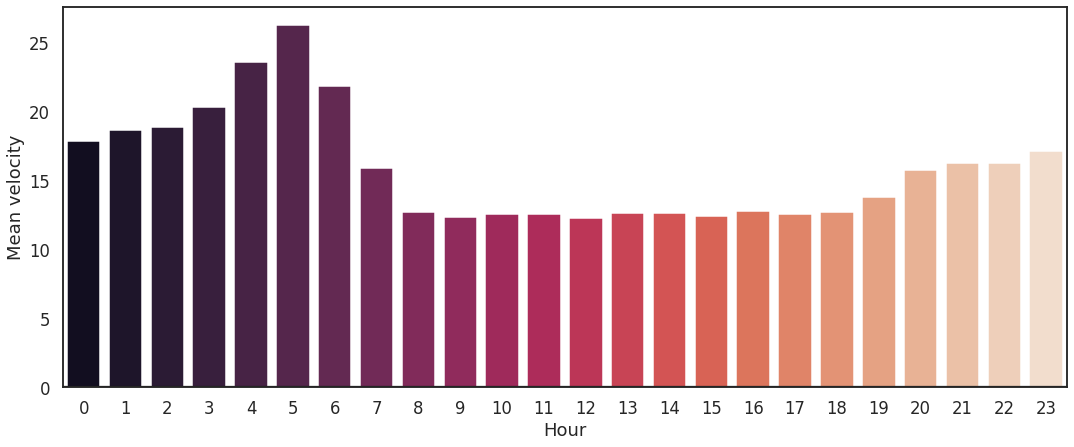

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", context="talk")

# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(18, 7))

# Generate some sequential data
sns.barplot(x=mean_df.pickup_datetime, y=mean_velocity_by_hour, palette="rocket", ax=ax1)
ax1.axhline(0, color="k")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Mean velocity")

The average speed shows an upward trend from **12 AM to 5 AM** with a peak at 5 AM. In addition, the average speed is stuck around 12.5km/h during the hours of **8 AM to 6 PM**. This most likely indicates that there is **increased traffic** during these hours, which is very reasonable since these are the hours when *people are going to and coming from their jobs*. We are going to further analyze the congestion in a separate section.

**Mean velocity by day**

In [ ]:
grouped_df = train_df.groupby(times.dt.weekday)
mean_df = grouped_df.mean()
mean_df = mean_df.reset_index()

mean_velocity_by_day = np.divide(np.array(mean_df['haversine_distance'])*1000, 
                                  np.array(mean_df['trip_duration']))*3.6

mean_velocity_by_day = list(mean_velocity_by_day)

Text(0, 0.5, 'Mean velocity')

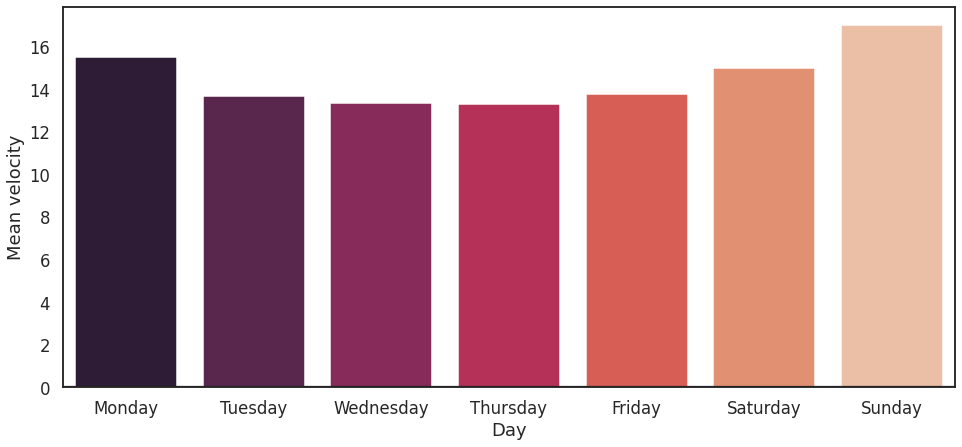

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", context="talk")

# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(16, 7))
daynames = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# Generate some sequential data
sns.barplot(x=daynames, y=mean_velocity_by_day, palette="rocket", ax=ax1)
ax1.axhline(0, color="k")
ax1.set_xlabel("Day")
ax1.set_ylabel("Mean velocity")

There is no visible relationship between days and average speed.

**Mean velocity by month**

In [ ]:
grouped_df = train_df.groupby(times.dt.month)
mean_df = grouped_df.mean()
mean_df = mean_df.reset_index()

mean_velocity_by_month = np.divide(np.array(mean_df['haversine_distance'])*1000, 
                                    np.array(mean_df['trip_duration']))*3.6

In [ ]:
mean_df['pickup_datetime'] = mean_df['pickup_datetime'].astype(int)

In [ ]:
mean_velocity_by_month

array([14.90186503, 14.82939647, 14.71670901, 14.18947998, 14.12131261,
       13.81103141])

In [ ]:
data_by_month = pd.DataFrame({"Month" : mean_df.pickup_datetime, "Velocity" : mean_velocity_by_month})

[Text(0, 0, 'Jan'),
 Text(0, 0, 'Feb'),
 Text(0, 0, 'Mar'),
 Text(0, 0, 'Apr'),
 Text(0, 0, 'May'),
 Text(0, 0, 'Jun')]

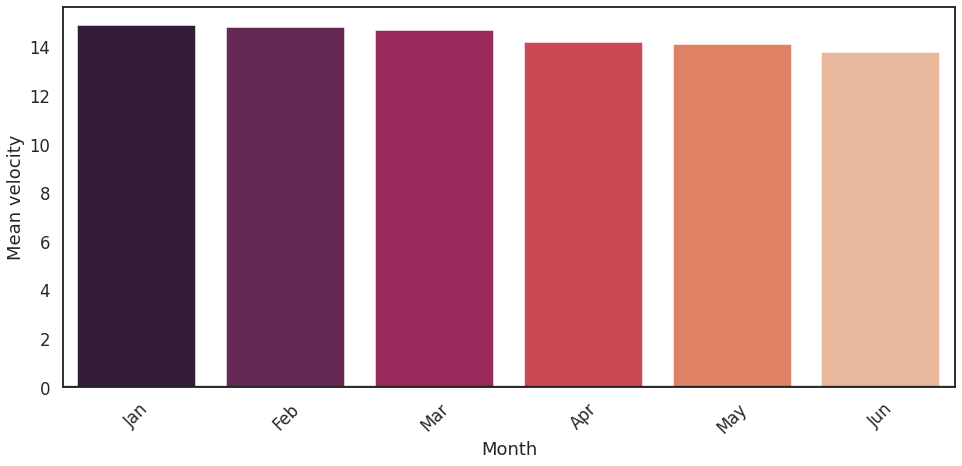

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", context="talk")

# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(16, 7))

# Generate some sequential data
sns.barplot(x=mean_df.pickup_datetime, y=mean_velocity_by_month, palette="rocket", ax=ax1)
ax1.axhline(0, color="k")
ax1.set_xlabel("Month")
ax1.set_ylabel("Mean velocity")
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'], rotation=45)

There is no visible relation between months and average speed.

#### **Q. 𝐈𝐗 -- Pickup & Dropoff**

**Pickup geolocations**

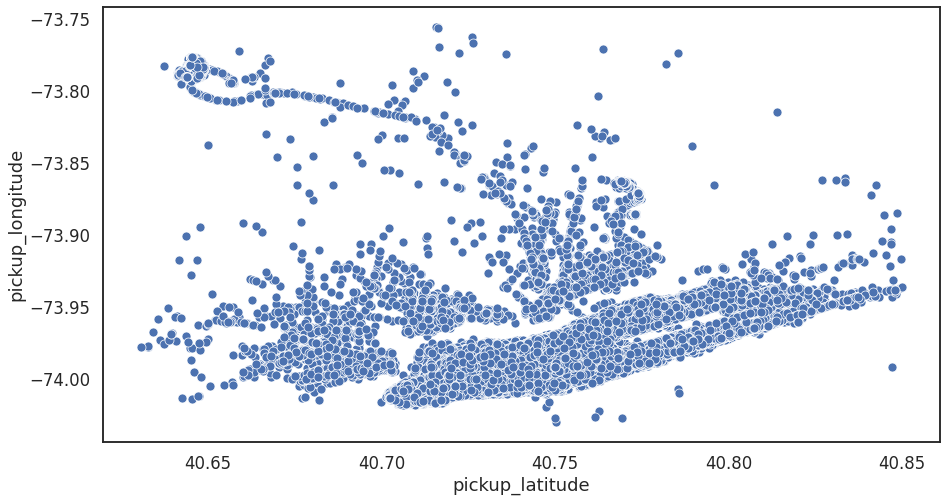

In [ ]:
pickup_data = pd.concat([train_df['pickup_latitude'], train_df['pickup_longitude']], axis=1)

sns.scatterplot(data=pickup_data, x="pickup_latitude", y="pickup_longitude")

**Dropoff geolocations**

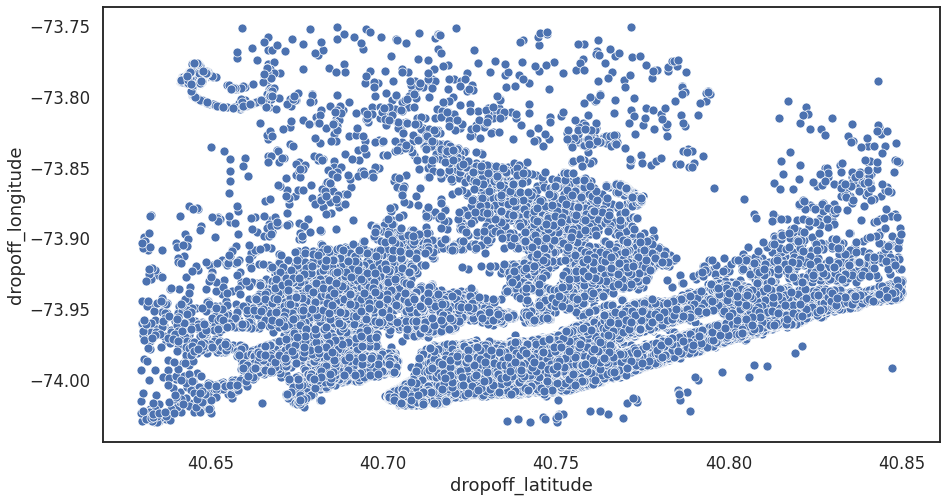

In [ ]:
dropoff_data = pd.concat([train_df['dropoff_latitude'], train_df['dropoff_longitude']], axis=1)

sns.scatterplot(data=dropoff_data, x="dropoff_latitude", y="dropoff_longitude")

## **Clustering** ⚫

As our data represent geographic locations (latitude, longitude) they do not need scaling. **K-Means may be sensitive to non-scaled data**, but as **our data has a well-defined meaning, so we should not scale it**, as this will cause distortion.

In [ ]:
X_train = train_df[['pickup_latitude', 'pickup_longitude']]

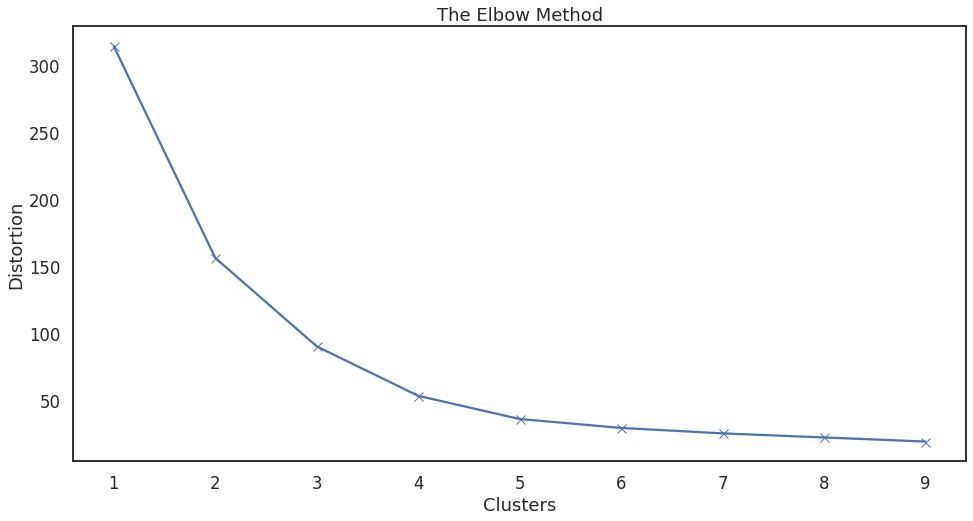

In [ ]:
from sklearn.cluster import KMeans

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_train)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

**Elbow**

Using the elbow method, we can see the elbow formed with **four** clusters. To determine the optimal number of clusters, we need to choose the value where the point after which the inertia starts to decrease linearly. This is when the "elbow" is formed.

In [ ]:
Kmean = KMeans(n_clusters=4)
Kmean.fit(X_train)

KMeans(n_clusters=4)

In [ ]:
centroids_x = Kmean.cluster_centers_[:,0]
centroids_y = Kmean.cluster_centers_[:,1]

In [ ]:
Kmean.labels_

array([1, 1, 0, ..., 1, 0, 1], dtype=int32)

In [ ]:
X_train.shape

(147752, 2)

In [ ]:
X_train

pickup_latitude  pickup_longitude
0             40.788368        -73.976501
1             40.769211        -73.992310
2             40.746391        -73.994713
3             40.718460        -73.988358
4             40.743576        -73.992332
...                 ...               ...
149994        40.752426        -73.978401
149995        40.773716        -73.870888
149996        40.789829        -73.973244
149997        40.737831        -73.991814
149998        40.760448        -73.983559

[147752 rows x 2 columns]

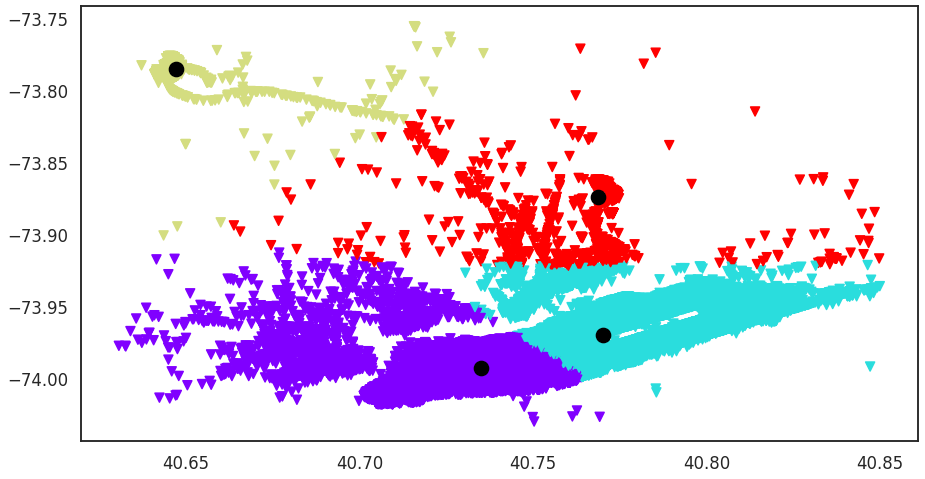

In [ ]:
plt.scatter(X_train['pickup_latitude'], X_train['pickup_longitude'],
            c=Kmean.labels_, marker='v', cmap='rainbow')

plt.scatter(centroids_x , centroids_y, s=200, c='black', marker='o')
plt.show()

## **Regression** 📈

Let's use the **Random Forest regressor** for predicting the trip duration. More specifically we are going to predict the *log* trip duration.

In [ ]:
X_train = train_df[['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
                            'dropoff_longitude', 'dropoff_latitude', 'pickup_hour', 'haversine_distance']]

In [ ]:
def season_number(month):
  if month in range(3,6):
    return 0 # Spring
  elif month in range(6,9):
    return 1 # Summer
  elif month in range(9,12):
    return 2 # Autumn
  else:
    return 3 # Winter

In [ ]:
def period_number(hour):
  if hour >= 6 and hour < 12:
    return 0 # Morning
  elif hour >= 12 and hour < 16:
    return 1 # Afternoon
  elif hour >= 16 and hour < 22:
    return 2 # Evening
  else:
    return 3 # Late Night

In [ ]:
X_train['pickup_day'] = train_df['pickup_datetime'].dt.dayofweek
X_train['pickup_month'] = train_df['pickup_datetime'].dt.month
X_train['pickup_season'] = train_df['pickup_datetime'].dt.month.apply(season_number)
X_train['pickup_day_period'] = train_df['pickup_datetime'].dt.hour.apply(period_number)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
X_train.shape

(147752, 12)

In [ ]:
X_test = test_df[['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
                            'dropoff_longitude', 'dropoff_latitude', 'pickup_hour', 'haversine_distance']]

In [ ]:
X_test['pickup_day'] = test_df['pickup_datetime'].dt.dayofweek
X_test['pickup_month'] = test_df['pickup_datetime'].dt.month
X_test['pickup_season'] = test_df['pickup_datetime'].dt.month.apply(season_number)
X_test['pickup_day_period'] = test_df['pickup_datetime'].dt.hour.apply(period_number)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
Y_train = train_df[['log_trip_duration']]

In [ ]:
Y_train = Y_train.values.ravel()

In [ ]:
Y_test = target_df[['trip_duration']]
Y_test['trip_duration'] = np.log2(Y_test['trip_duration'])
Y_test = Y_test.values.ravel()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Fit RF regressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# fit the regressor with x and y data
regressor.fit(X_train, Y_train)

RandomForestRegressor(random_state=0)

**Predict**

In [ ]:
Y_pred = regressor.predict(X_test)

**MAE & MSE** (Mean Absolute & Squared Error) 

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)

print("Minimum Absolute Error (MAE): ", mae)
print("Minimum Squared Error (MSE): ", mse)

Minimum Absolute Error (MAE):  0.3966748126479814
Minimum Squared Error (MSE):  0.3854736243249501


**Feature Importances**

In [ ]:
import time
import numpy as np

start_time = time.time()
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.576 seconds


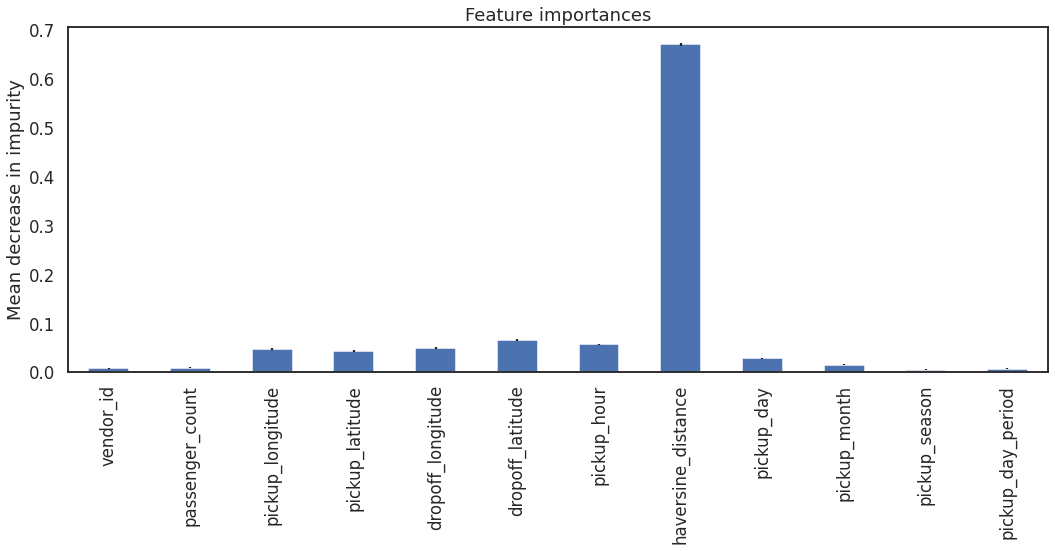

In [ ]:
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### **Fit & predict with the most important features**

We will try to fit the regressor with just **the 6 more important features** according to the above plot.

In [ ]:
X_train_most_important = train_df[['haversine_distance', 'pickup_latitude', 'pickup_longitude',
                                   'dropoff_latitude', 'dropoff_longitude', 'pickup_hour']]

X_train_most_important['pickup_day'] = train_df['pickup_datetime'].dt.dayofweek

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
X_test_most_important = test_df[['haversine_distance', 'pickup_latitude', 'pickup_longitude',
                                   'dropoff_latitude', 'dropoff_longitude', 'pickup_hour']]

X_test_most_important['pickup_day'] = test_df['pickup_datetime'].dt.dayofweek

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# fit the regressor with x and y data
regressor.fit(X_train_most_important, Y_train)

RandomForestRegressor(random_state=0)

In [ ]:
Y_pred_most_important = regressor.predict(X_test_most_important)

In [ ]:
mae = mean_absolute_error(Y_test, Y_pred_most_important)
mse = mean_squared_error(Y_test, Y_pred_most_important)

print(mae)
print(mse)

0.3983074581794209
0.39361970185415973


We may have omitted some less important features, but as it turns out, these also contribute, even if only slightly, to reducing the error. Thus, we keep all features for the regressor.

### **Hyperparameter Tuning `(GridSearchCV)`**

We use `GridSearchCV` for finding the optimal parameters of Random Forest Regressor.  
As scoring metric we use the (negative) Minimum Absolute Error.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


## Define GridSearch parameters to try 
parameters = { 
    'n_estimators': [100, 200, 300],
    'max_depth' : [2, 8, 16],
    'max_features' : ['sqrt', 'log2'],
    'random_state' : [1]
}

scoring = {"MAE": "neg_mean_absolute_error", "MSE": 'neg_mean_squared_error'}

## Grid Search function
BestRFR = GridSearchCV(estimator=RandomForestRegressor(), param_grid=parameters, 
                       scoring = 'neg_mean_absolute_error', cv=5)
BestRFR.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 8, 16],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300], 'random_state': [1]},
             scoring='neg_mean_absolute_error')

**Predict using best hyperparameters**

In [ ]:
Y_pred = BestRFR.predict(X_test)

**Best MAE & MSE scores**

In [ ]:
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)

print(mae)
print(mse)

0.4105785901132999
0.40231975674775206


In [ ]:
print(" Results from Grid Search " )
print("\n Optimal parameters: \n", BestRFR.best_params_)
print("\n Minimum MAE achieved: \n", -BestRFR.best_score_)

 Results from Grid Search 

 Optimal parameters: 
 {'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 300, 'random_state': 1}

 Minimum MAE achieved: 
 0.40273160322336626


As we can see RF performs slightly better with the original values due to the maximum depth not being limited unlike `GridSearchCV` which limited it to 16. **The difference in error is almost negligible.**

**Regressor line plot**

In [ ]:
plot_Y = pd.DataFrame({'Y_pred' : Y_pred, 'Y_test' : Y_test})

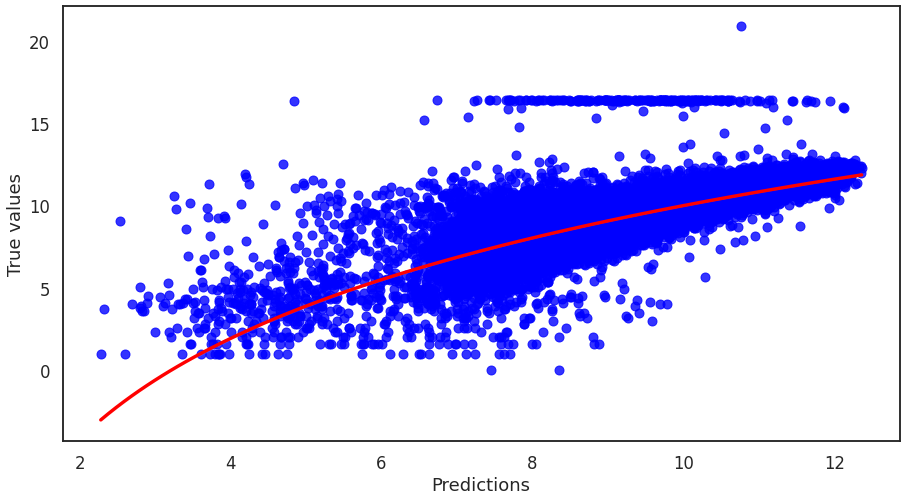

In [ ]:
ax = sns.regplot(x="Y_pred", y="Y_test", data=plot_Y, logx=True, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
ax.set(xlabel='Predictions', ylabel='True values')
plt.show()

## **New York Map** 🗺️

In [ ]:
import folium # goelogical map

nyc_centre_lat = 40.730610
nyc_centre_lon = -73.935242
nyc_map = folium.Map(location=[nyc_centre_lat, nyc_centre_lon], tiles='OpenStreetMap', zoom_start=12)

for ride in train_df[:1000].iterrows():
    folium.CircleMarker([ride[1]['pickup_latitude'],ride[1]['pickup_longitude']],
                        radius=3,
                        color='blue',
                        popup=str(ride[1]['pickup_latitude'])+','+str(ride[1]['pickup_longitude']),
                        fill_color='#FD8A6C'
                        ).add_to(nyc_map)

nyc_map

## **Bonus Data Analysis** 🔬

### **Most common vendor**

In [ ]:
grouped_per_vendor = train_df.groupby('vendor_id').size()
grouped_per_vendor

vendor_id
1    68791
2    78961
dtype: int64

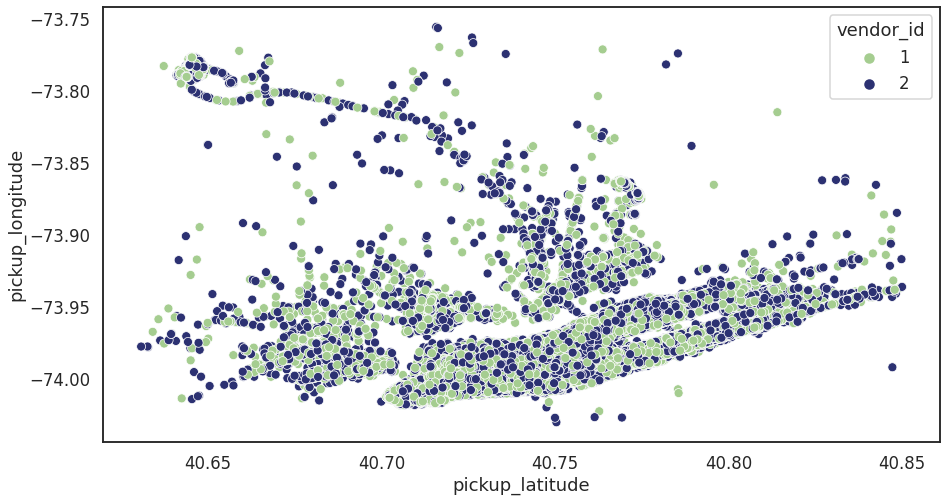

In [ ]:
sns.scatterplot(data=train_df, x="pickup_latitude", y="pickup_longitude", hue="vendor_id", palette="crest")

### **Analyze Congestion**

According to the mean velocity we calculated per hour, per day and per month, we can derive the following:

**Lower average speeds means increased congestion.** As we have the average speeds (analyzed in `Mean Velocity` section) we can draw conclusions about the congestion or the peak traffic times. 

* The **days with peak traffic are Saturday, Sunday, and Monday**
* The **rush hours in NYC are from 8 AM to 7 PM**

As you can see [here](https://www.tomtom.com/en_gb/traffic-index/new-york-traffic/), the peak hours for 2021 are from 7 AM to 6 PM, which is very close to our measurements.

We tried other measurement techniques, such as dividing the New York City map into segments and analyzing how many pickup points there were in each segment each hour, but we came up with a large, complicated code that produced the above conclusions, which can already be seen from the analysis of average speed per hour we did earlier. This makes a lot of sense since the average speed per hour in downtown NYC is inversely proportional to the traffic there. That is, it is a simple metric but one that seems to work for our case.

**Plot congestion level per hour**

**The inverse of the average speed per hour**, which shows how slowly cars are moving, and therefore how much congestion there is.

In [ ]:
times = pd.to_datetime(train_df.pickup_datetime)

In [ ]:
grouped_df = train_df.groupby(times.dt.hour)
mean_df = grouped_df[['haversine_distance', 'trip_duration']].mean()
mean_df = mean_df.reset_index()

congestion_level_per_hour = 1 / np.divide(np.array(mean_df['haversine_distance'])*1000, 
                                  np.array(mean_df['trip_duration']))*3.6

congestion_level_per_hour = list(congestion_level_per_hour)

In [ ]:
mean_df['pickup_datetime'] = mean_df['pickup_datetime'].astype(int)

Text(0, 0.5, 'Congestion Level')

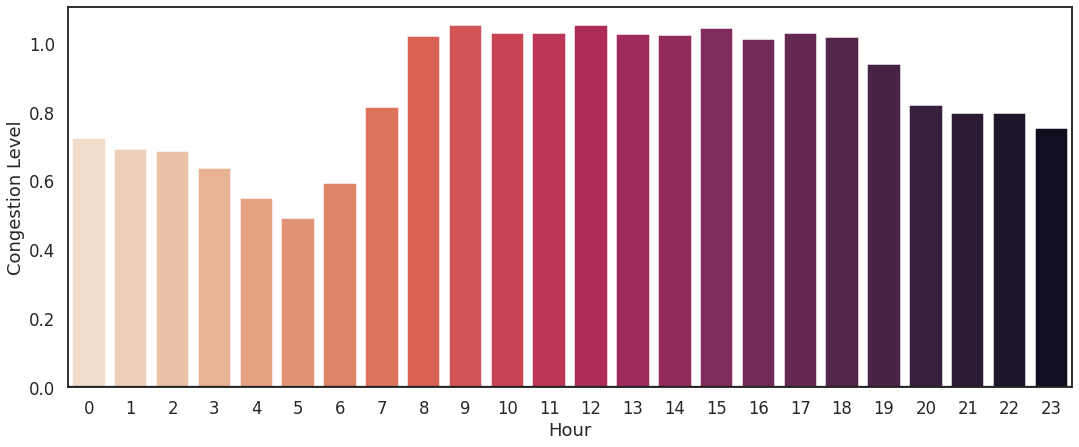

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", context="talk")

# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(18, 7))

# Generate some sequential data
sns.barplot(x=mean_df.pickup_datetime, y=congestion_level_per_hour, palette="rocket_r", ax=ax1)
ax1.axhline(0, color="k")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Congestion Level")

## **Adding features** 💡

We will try to think of some new features to consider and see if these will help our regressor achieve better scores.

### **Feature #1: Weekend Trips**

The first attribute we will add to the data is **a boolean value indicating whether the trip was made on the weekend or not. The average trip duration is sligthly lower on the weekend** (as we can see below), so, this this is a good indicator to consider. 

In [ ]:
## Add new feature to dataset ##
def set_if_on_weekend(dayname):
  if dayname == 'Saturday' or dayname == 'Sunday':
    return True
  return False

train_df['on_weekend'] = train_df['pickup_day_name'].apply(set_if_on_weekend)
test_df['on_weekend'] = test_df['pickup_day_name'].apply(set_if_on_weekend)

Let's see the **average trip duration on weekend and non-weekend trips**.

In [ ]:
grouped_per_weekend = train_df.groupby('on_weekend')['trip_duration'].agg(['sum','count'])

grouped_per_weekend['avg_trip_dur'] = grouped_per_weekend['sum']/grouped_per_weekend['count']/60

grouped_per_weekend

sum   count  avg_trip_dur
on_weekend                                
False       89450378  105591     14.119003
True        32024307   42161     12.659530

### **Feature #2: Trips on busy hours**

The second attribute we will add to the data is again a boolean value that this time will indicate **whether the trip was made at peak traffic time**. As we have seen in our traffic analysis, **the hours from 8 AM to 7 PM are peak hours with lower average taxi speeds and therefore more traffic**. Therefore this will also affect our estimate of travel time, and we should consider it.

In [ ]:
def keep_busy_trips(hour):
  if hour >= 8 and hour <= 19:
    return True
  return False

In [ ]:
train_df['busy_hour'] = train_df['pickup_datetime'].dt.hour.apply(keep_busy_trips)
test_df['busy_hour'] = test_df['pickup_datetime'].dt.hour.apply(keep_busy_trips)

In [ ]:
test_df

id  vendor_id     pickup_datetime  passenger_count  \
0       id3206885          2 2016-03-16 05:59:42                5   
1       id2931797          1 2016-04-14 13:37:36                1   
2       id0759548          1 2016-06-06 14:03:22                1   
3       id1998257          1 2016-04-21 12:21:54                1   
4       id2645175          2 2016-01-12 20:10:05                1   
...           ...        ...                 ...              ...   
149995  id0017144          2 2016-05-30 18:18:57                3   
149996  id3325591          2 2016-04-03 09:35:13                1   
149997  id0465652          2 2016-05-12 22:51:49                2   
149998  id3702556          1 2016-04-01 16:03:09                1   
149999  id2016618          1 2016-03-05 22:54:21                1   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
0             -73.977753        40.764610         -73.991142   
1             -73.996925        40.732578         -73.997932   
2             -74.006149        40.749966         -74.013985   
3             -73.967941        40.762707         -73.983833   
4             -73.973351        40.763561         -73.987679   
...                  ...              ...                ...   
149995        -73.994492        40.702820         -73.979607   
149996        -73.993408        40.751598         -74.002350   
149997        -73.983360        40.723568         -73.953392   
149998        -73.982056        40.767204         -74.000366   
149999        -73.983559        40.749504         -73.994232   

        dropoff_latitude store_and_fwd_flag pickup_day_period pickup_day_name  \
0              40.770260                  N        Late Night       Wednesday   
1              40.755642                  N         Afternoon        Thursday   
2              40.713726                  N         Afternoon          Monday   
3              40.742435                  N         Afternoon        Thursday   
4              40.738201                  N           Evening         Tuesday   
...                  ...                ...               ...             ...   
149995         40.754990                  N           Evening          Monday   
149996         40.755970                  N           Morning          Sunday   
149997         40.779560                  N        Late Night        Thursday   
149998         40.719749                  N           Evening          Friday   
149999         40.756275                  N        Late Night        Saturday   

       pickup_month  pickup_hour  pickup_year pickup_season  \
0             March            5         2016        Spring   
1             April           13         2016        Spring   
2              June           14         2016        Summer   
3             April           12         2016        Spring   
4           January           20         2016        Winter   
...             ...          ...          ...           ...   
149995          May           18         2016        Spring   
149996        April            9         2016        Spring   
149997          May           22         2016        Spring   
149998        April           16         2016        Spring   
149999        March           22         2016        Spring   

        haversine_distance  on_weekend  busy_hour  
0                 1.290790       False      False  
1                 2.565965       False       True  
2                 4.083388       False       True  
3                 2.621603       False       True  
4                 3.067347       False      False  
...                    ...         ...        ...  
149995            5.935064       False       True  
149996            0.896424        True       True  
149997            6.718342       False      False  
149998            5.497592       False       True  
149999            1.172690        True      False  

[150000 rows x 18 columns]

## **Re-Regression** 🔁

It's time to reapply the Random Forest Regressor to our dataset with the new features.

In [ ]:
X_train_v2 = X_train

In [ ]:
def bool2int(x):
  if x:
    return float(1)
  return float(0)

In [ ]:
X_train_v2['busy_hour'] = train_df['busy_hour'].apply(bool2int)
X_train_v2['on_weekend'] = train_df['on_weekend'].apply(bool2int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
X_train_v2

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0               2                1        -73.976501        40.788368   
1               2                1        -73.992310        40.769211   
2               2                1        -73.994713        40.746391   
3               2                1        -73.988358        40.718460   
4               1                1        -73.992332        40.743576   
...           ...              ...               ...              ...   
149994          1                2        -73.978401        40.752426   
149995          2                4        -73.870888        40.773716   
149996          1                1        -73.973244        40.789829   
149997          2                6        -73.991814        40.737831   
149998          2                5        -73.983559        40.760448   

        dropoff_longitude  dropoff_latitude  pickup_hour  haversine_distance  \
0              -73.957657         40.782452            8            1.717570   
1              -73.990662         40.758137           11            1.239177   
2              -73.969742         40.758484           19            2.496477   
3              -73.951538         40.713840            0            3.145381   
4              -73.979309         40.678200           18            7.351920   
...                   ...               ...          ...                 ...   
149994         -73.989975         40.750263           14            1.004154   
149995         -73.925484         40.767742           19            4.645324   
149996         -73.963272         40.798786            0            1.302526   
149997         -73.984528         40.763969           14            2.970543   
149998         -74.016068         40.714668           16            5.780606   

        pickup_day  pickup_month  pickup_season  pickup_day_period  busy_hour  \
0                5             4              0                  0        1.0   
1                3             4              0                  0        1.0   
2                4             4              0                  2        1.0   
3                3             4              0                  3        0.0   
4                1             1              3                  2        1.0   
...            ...           ...            ...                ...        ...   
149994           2             3              0                  1        1.0   
149995           0             5              0                  2        1.0   
149996           6             1              3                  3        0.0   
149997           4             1              3                  1        1.0   
149998           6             5              0                  2        1.0   

        on_weekend  
0              1.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
...            ...  
149994         0.0  
149995         0.0  
149996         1.0  
149997         0.0  
149998         1.0  

[147752 rows x 14 columns]

In [ ]:
X_test_v2 = X_test

In [ ]:
X_test_v2['busy_hour'] = test_df['busy_hour'].apply(bool2int)
X_test_v2['on_weekend'] = test_df['on_weekend'].apply(bool2int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# fit the regressor with x and y data
regressor.fit(X_train_v2, Y_train)

RandomForestRegressor(random_state=0)

In [ ]:
Y_pred_v2 = regressor.predict(X_test_v2)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(Y_test, Y_pred_v2)
mse = mean_squared_error(Y_test, Y_pred_v2)

print(mae)
print(mse)

0.3969004546594159
0.38535135873521836


**Feature Importances**

In [ ]:
import time
import numpy as np

start_time = time.time()
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.522 seconds


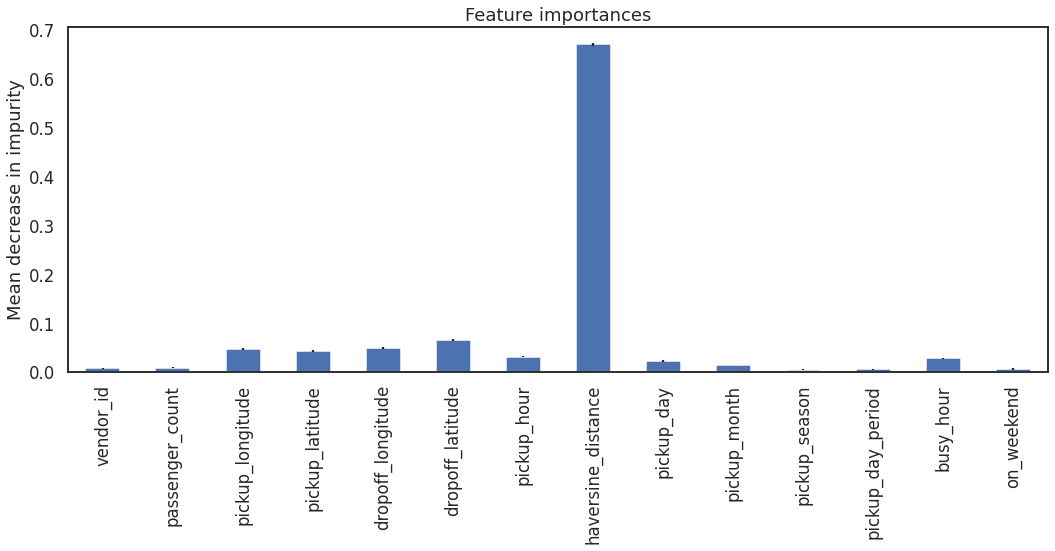

In [ ]:
forest_importances = pd.Series(importances, index=X_train_v2.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

As we can see, of the two features we added, **the most useful was the trips made during peak hours**, but the other feature also contributed (very little).

**Plot regressor line**

In [ ]:
plot_Y = pd.DataFrame({'Y_pred' : Y_pred_v2, 'Y_test' : Y_test})

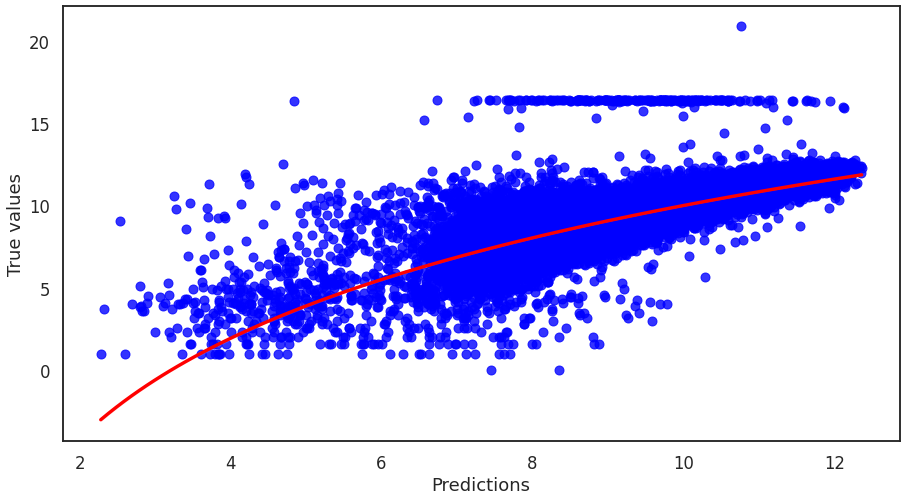

In [ ]:
ax = sns.regplot(x="Y_pred", y="Y_test", data=plot_Y, logx=True, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
ax.set(xlabel='Predictions', ylabel='True values')
plt.show()

## **Summary** 💭

In this notebook we experimented with data from taxi trips in New York City. We separated pick-up and drop-off points using clustering and also fitted a regressor to predict average trip duration. In addition, we looked extensively at some analysis for average taxi speed, as well as for peak traffic hours and beyond. We drew some useful graphs and I think we got a good sample of understanding of our data.

As this dataset has more than 1M lines, we decided to run this notebook with just 150K of them, otherwise RF would run forever.

Some numbers to point:

* Random Forest Regressor with `{'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 300, 'random_state': 1}` got:
  * **Best (lowest) MAE** = 0.39
  * **Best (lowest) MSE** = 0.36

**Authors:**

* Angelos Poulis
* Dimitrios Kyriakopoulos

 